In [1]:
!ls /kaggle/input/emotion-dataset/

test.csv  training.csv	validation.csv


In [2]:
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local', 
                         page_size=10)
    
    
pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

validation = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information:

Training data: (16000, 2)

Validation data: (2000, 2)

Test data: (2000, 2)


In [3]:
show_panel(train)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [4]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Don't forget the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets 
emotions = DatasetDict({
    "train": Dataset.from_pandas(train,features=ft),
    "test": Dataset.from_pandas(test,features=ft),
    "validation": Dataset.from_pandas(validation,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [7]:
# Convert Dataset to DataFrame (don't forget to reset)
emotions.set_format(type="pandas")
df = emotions["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [8]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [9]:
import plotly.express as px

px.bar(df['label_name'].value_counts(ascending=True),template='plotly_white')

In [10]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

px.box(df,y='Words Per Tweet',
       color='label_name',
       template='plotly_white')

In [11]:
text = 'Tokenisation of text is a core task of NLP.'
tokenised_text = list(text)

# Character Tokenised list
print(f'Number of tokens: {len(tokenised_text)}')
print(tokenised_text)

Number of tokens: 43

['T', 'o', 'k', 'e', 'n', 'i', 's', 'a', 't', 'i', 'o', 'n', ' ', 'o', 'f', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [12]:
# Mapping Vecabulary dictionary
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenised_text)))}

print(f'Length of vocabulary: {len(token2idx)}')
print(token2idx)

Length of vocabulary: 18

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17}


In [13]:
# Let's represent text in numerical format 
input_ids = [token2idx[token] for token in tokenised_text]

print(f'{len(input_ids)} characters')
print(input_ids)

43 characters

[5, 13, 11, 8, 12, 10, 15, 6, 16, 10, 13, 12, 0, 13, 9, 0, 16, 8, 17, 16, 0, 10, 15, 0, 6, 0, 7, 13, 14, 8, 0, 16, 6, 15, 11, 0, 13, 9, 0, 3, 2, 4, 1]


In [14]:
import torch
import torch.nn.functional as F

inputs_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(inputs_ids,num_classes = len(token2idx))
print(f'OHE size: {one_hot_encodings.shape}')

OHE size: torch.Size([43, 18])


In [15]:
tokenised_text = text.split()
print(tokenised_text)

['Tokenisation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [16]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Show tokeniser information
tokenizer

# Or we can load the Tokeniser manually `transformers.DistilBertTokenizer`

# from transformers import DistilBertTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
# distilbert_tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [17]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')



Vocab size: 30522

Max length: 512

Tokeniser model input names: ['input_ids', 'attention_mask']


In [18]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text

{'input_ids': [101, 19204, 6648, 1997, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 



Tokens

['[CLS]', 'token', '##isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]'] 



Convert tokens to string

[CLS] tokenisation of text is a core task of nlp. [SEP] 




In [19]:
emotions.reset_format()

In [20]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Show the tokenised ids
ex_tokenised = tokenise(emotions["train"][:2])

In [21]:
# Show attention mask
ex_tokenised['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [22]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [23]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...

To disable this warning, you can either:

	- Avoid using `tokenizers` before the fork if possible

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...

To disable this warning, you can either:

	- Avoid using `tokenizers` before the fork if possible

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...

To disable this warning, you can either:

	- Avoid using `tokenizers` before the fork if possible

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']

- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [25]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],

         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],

         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],

         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],

         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],

         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],

       device='cuda:0'), hidden_states=None, attentions=None)


In [26]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])

torch.Size([1, 768])


In [27]:
def extract_hidden_states(batch):
    
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [28]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [29]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (16000, 768)

Validation Dataset (2000, 768)


In [31]:
# Let's check our dataset 
X_train

array([[-0.11675112,  0.0985712 , -0.1296294 , ...,  0.05871103,
         0.35432687,  0.4042069 ],
       [-0.03236276, -0.032315  , -0.19572599, ..., -0.17465746,
         0.35463798,  0.30276588],
       [ 0.03974653,  0.20223357,  0.14227144, ..., -0.11406811,
         0.33937755,  0.39583102],
       ...,
       [-0.00339851, -0.09585507,  0.05843527, ..., -0.04272686,
         0.24959192,  0.30761606],
       [ 0.06660312,  0.17334336,  0.12896673, ...,  0.06118574,
         0.29038203,  0.46844172],
       [ 0.0166881 ,  0.10127111, -0.00731735, ..., -0.06493614,
         0.34540522,  0.21993555]], dtype=float32)

In [32]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_train

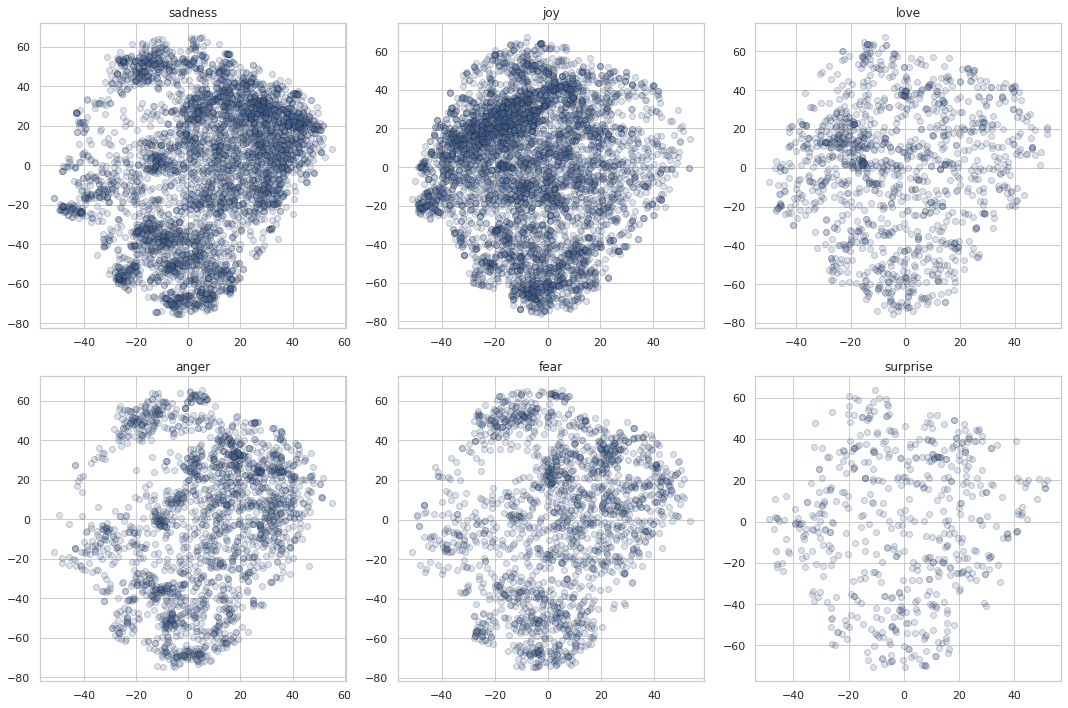

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
labels = emotions["train"].features["label"].names

for i, label in enumerate(labels):
    
    dict_embedding_sub = dict(tuple(df_embedding.groupby('label')))
    df_embedding_sub = dict_embedding_sub[i]                        
                            
    axes[i].scatter(df_embedding_sub["X"], 
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.2)
    
    axes[i].set_title(f'{label}')

plt.tight_layout()
plt.show()

In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'accuracy: {dummy_clf.score(X_valid, y_valid)}')

accuracy: 0.352


In [35]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.6335


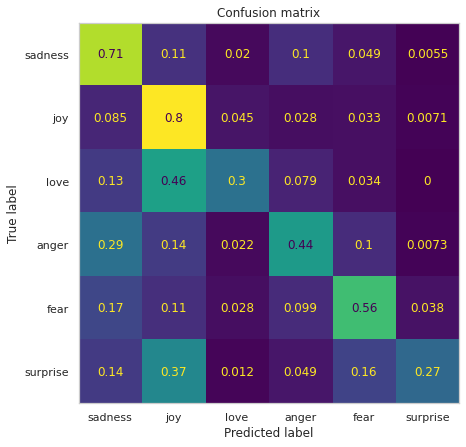

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

In [37]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, 
                          num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']

- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_class

In [38]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [39]:
from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False, 
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [40]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.815600,0.283547,0.910000,0.908837
2,0.210600,0.177810,0.924000,0.923975
3,0.145300,0.164301,0.932000,0.932019


TrainOutput(global_step=750, training_loss=0.39048492431640625, metrics={'train_runtime': 216.736, 'train_samples_per_second': 221.468, 'train_steps_per_second': 3.46, 'total_flos': 1080514292544000.0, 'train_loss': 0.39048492431640625, 'epoch': 3.0})

In [41]:
# Predict on Validation Dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[ 4.9410048 , -0.9710053 , -1.3515826 , -1.1116846 , -1.0898885 ,
        -1.9487453 ],
       [ 4.818119  , -1.1127146 , -1.9818817 , -1.0774915 , -0.65260357,
        -1.7378302 ],
       [-1.119442  ,  2.833617  ,  3.0507257 , -1.4476018 , -1.516956  ,
        -1.7326051 ],
       ...,
       [-1.1710193 ,  5.1207647 , -0.46514907, -1.379367  , -1.4806994 ,
        -1.1397643 ],
       [-1.6916549 ,  3.420438  ,  2.9571507 , -1.487854  , -1.4718724 ,
        -1.4209768 ],
       [-1.443461  ,  5.2022133 , -0.72265613, -1.5220037 , -1.3820721 ,
        -0.49238342]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.1643010526895523, 'test_accuracy': 0.932, 'test_f1': 0.9320189123198845, 'test_runtime': 2.7114, 'test_samples_per_second': 737.632, 'test_steps_per_second': 11.802})

In [42]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (2000, 6)

[[ 4.9410048  -0.9710053  -1.3515826  -1.1116846  -1.0898885  -1.9487453 ]

 [ 4.818119   -1.1127146  -1.9818817  -1.0774915  -0.65260357 -1.7378302 ]

 [-1.119442    2.833617    3.0507257  -1.4476018  -1.516956   -1.7326051 ]

 ...

 [-1.1710193   5.1207647  -0.46514907 -1.379367   -1.4806994  -1.1397643 ]

 [-1.6916549   3.420438    2.9571507  -1.487854   -1.4718724  -1.4209768 ]

 [-1.443461    5.2022133  -0.72265613 -1.5220037  -1.3820721  -0.49238342]]


In [43]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions,axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(2000,)

Predictions: [0 0 2 ... 1 1 1]


In [44]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.1643010526895523,
 'test_accuracy': 0.932,
 'test_f1': 0.9320189123198845,
 'test_runtime': 2.7114,
 'test_samples_per_second': 737.632,
 'test_steps_per_second': 11.802}

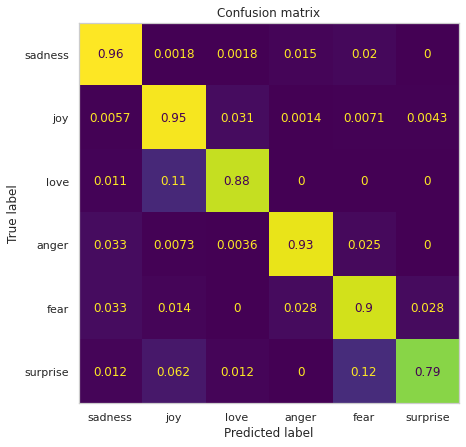

In [45]:
plot_confusion_matrix(y_preds,y_valid,labels)

In [46]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True, 
                                                                    batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [47]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [48]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [49]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [50]:
# Save the model
trainer.save_model()

In [51]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

In [52]:
preds = classifier(new_data, return_all_scores=True)
preds

[{'label': 'LABEL_0', 'score': 0.0026111453771591187},
 {'label': 'LABEL_1', 'score': 0.9835193753242493},
 {'label': 'LABEL_2', 'score': 0.0020527481101453304},
 {'label': 'LABEL_3', 'score': 0.0021536240819841623},
 {'label': 'LABEL_4', 'score': 0.0023421754594892263},
 {'label': 'LABEL_5', 'score': 0.00732091860845685}]

In [53]:
preds[0]

{'label': 'LABEL_0', 'score': 0.0026111453771591187}

In [54]:
df_preds = pd.DataFrame(preds)
px.bar(x=labels,y=100*df_preds['score'],template='plotly_white')